# MailRU Machine Learning Tutorial Realisation

## Анализ данных

### Загрузим данные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.style.use('ggplot')

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data = pd.read_csv(url, header=None, na_values = '?')
data.columns = ['A' + str(i) for i in range(1, 16)] + ['class']


categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

### Изучим данные

In [2]:
data.shape

(690, 16)

In [3]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+


In [4]:
data.tail()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0,t,g,0,0,-


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000003ACDD30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BEEBA90>]], dtype=object)

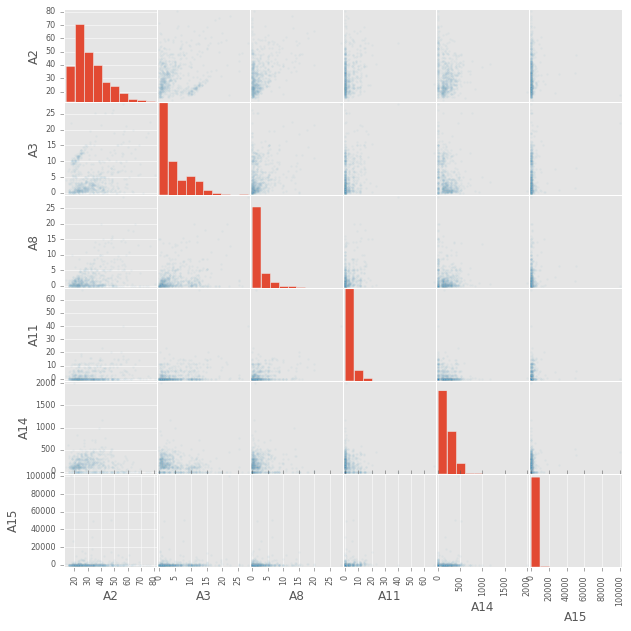

In [5]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data, alpha=0.05, figsize=(10, 10))

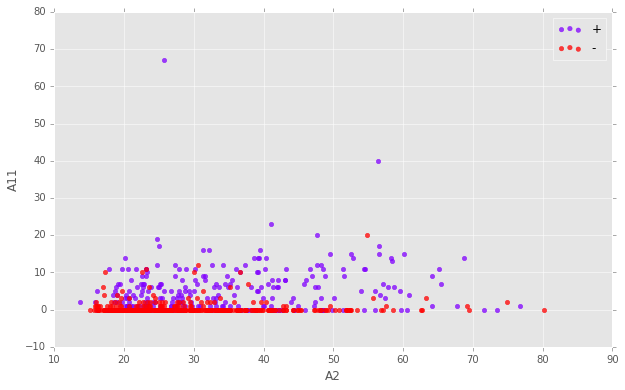

In [5]:
import scatter_matrix_with_categoricals as smc
smc.scatter_matrix_with_categoricals(data, 'A2', 'A11', 'class')

### Подготовим данные для sci-kit learn

In [4]:
# Заполняем пропуски в данных
data = data.fillna(data.median(axis=0), axis=0)
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

# Превращаем качественные паременные в бинарные там, где 2 типа (t или f, например)
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1
    
# Создаем dummy для качественных переменных    
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
data_nonbinary = pd.get_dummies(data[nonbinary_columns])

# Нормализация числовых данных
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()

# Объединяем все обратно в одну таблицу
data = pd.concat((data_numerical, data[binary_columns], data_nonbinary), axis=1)
data = pd.DataFrame(data, dtype=float)

# Выбрасываем столбец 'class'.
X = data.drop(('class'), axis=1)  
y = data['class']
feature_names = X.columns
N, d = X.shape

# Разбиваем выборку на тестовую и обучающаю
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 11)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print N_train, N_test

483 207


## Обучение моделей

### k ближайших соседей

In [8]:
# Обучаем модель
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Считаем ошибку
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)
print 'Ошибка на обучающей выборке:',err_train, '| Ошибка на тестовой выборке:',err_test

0.146997929607 0.169082125604


In [18]:
# Выбираем оптимальное k
from sklearn.grid_search import GridSearchCV
n_neighbors_array = [1, 3, 5, 7, 10, 15]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors_array})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print 'Выбираем оптимальное k:'
print best_cv_err, best_n_neighbors

# Обучаем на основании лучшего значения
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))
print 'Ошибки на основании оптимального k:'
print 'Ошибка на обучающей выборке:',err_train, '| Ошибка на тестовой выборке:',err_test

Выбираем оптимальное k:
0.207039337474 7
Ошибки на основании оптимального k:
Ошибка на обучеющей выборке: 0.151138716356 | Ошибка на тестовой выборке: 0.164251207729


### SVC (метод опорных векторов)

In [5]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
print err_train, err_test

0.144927536232 0.130434782609


In [7]:
# Вначале попробуем найти лучшие значения параметров для радиального ядра
from sklearn.grid_search import GridSearchCV
C_array = np.logspace(-3, 3, num=7)
gamma_array = np.logspace(-5, 2, num=8)
svc = SVC(kernel='rbf')
grid = GridSearchCV(svc, param_grid={'C': C_array, 'gamma': gamma_array})
grid.fit(X_train, y_train)
print 'CV error    = ', 1 - grid.best_score_
print 'best C      = ', grid.best_estimator_.C
print 'best gamma  = ', grid.best_estimator_.gamma

# Обучаем на основании лучшего значения
svc = SVC(kernel='rbf', C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma)
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
print err_train, err_test

CV error    =  0.138716356108
best C      =  1.0
best gamma  =  0.01
0.134575569358 0.111111111111


In [8]:
# Теперь рассмотрим линейное ядро.
from sklearn.grid_search import GridSearchCV
C_array = np.logspace(-3, 3, num=7)
svc = SVC(kernel='linear')
grid = GridSearchCV(svc, param_grid={'C': C_array})
grid.fit(X_train, y_train)
print 'CV error    = ', 1 - grid.best_score_
print 'best C      = ', grid.best_estimator_.C

# Обучаем на основании лучшего значения
svc = SVC(kernel='linear', C=grid.best_estimator_.C)
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
print err_train, err_test

CV error    =  0.151138716356
best C      =  0.1
0.151138716356 0.125603864734


In [9]:
# Попробуем также полиномиальное ядро
from sklearn.grid_search import GridSearchCV
C_array = np.logspace(-5, 2, num=8)
gamma_array = np.logspace(-5, 2, num=8)
degree_array = [2, 3, 4]
svc = SVC(kernel='poly')
grid = GridSearchCV(svc, param_grid={'C': C_array, 'gamma': gamma_array, 'degree': degree_array})
grid.fit(X_train, y_train)
print 'CV error    = ', 1 - grid.best_score_
print 'best C      = ', grid.best_estimator_.C
print 'best gamma  = ', grid.best_estimator_.gamma
print 'best degree = ', grid.best_estimator_.degree

# Обучаем на основании лучшего значения
svc = SVC(kernel='poly', C=grid.best_estimator_.C, 
          gamma=grid.best_estimator_.gamma, degree=grid.best_estimator_.degree)
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))
print err_train, err_test

CV error    =  0.138716356108
best C      =  0.0001
best gamma  =  10.0
best degree =  2
0.0973084886128 0.12077294686


### Random Forest – случайный лес

In [18]:
#Обучаем модель
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print err_train, err_test

#Ищем лучшее значение n_estimators
from sklearn.grid_search import GridSearchCV
n_estimators_array = [90,100,110,125,150,200,250]
grid = GridSearchCV(rf, param_grid={'n_estimators' : n_estimators_array})
grid.fit(X_train, y_train)
print 'CV error    = ', 1 - grid.best_score_
print 'best C      = ', grid.best_estimator_.n_estimators

# Обучаем на основании лучшего значения
rf = ensemble.RandomForestClassifier(n_estimators=grid.best_estimator_.n_estimators, 
                                     random_state=11)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print err_train, err_test

0.0 0.101449275362
CV error    =  0.134575569358
best C      =  150
0.0 0.106280193237


In [19]:
# Отбор наиболее важных признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'A9   ' (0.2334)
 2. feature 'A8   ' (0.1034)
 3. feature 'A11  ' (0.0832)
 4. feature 'A15  ' (0.0817)
 5. feature 'A3   ' (0.0777)
 6. feature 'A14  ' (0.0758)
 7. feature 'A2   ' (0.0634)
 8. feature 'A10  ' (0.0613)
 9. feature 'A6_x ' (0.0148)
10. feature 'A12  ' (0.0138)
11. feature 'A7_h ' (0.0131)
12. feature 'A1   ' (0.0130)
13. feature 'A6_k ' (0.0121)
14. feature 'A7_v ' (0.0112)
15. feature 'A6_q ' (0.0110)
16. feature 'A13_g' (0.0094)
17. feature 'A5_p ' (0.0093)
18. feature 'A6_w ' (0.0093)
19. feature 'A5_g ' (0.0086)
20. feature 'A6_ff' (0.0086)
21. feature 'A4_y ' (0.0084)
22. feature 'A4_u ' (0.0083)
23. feature 'A6_c ' (0.0082)
24. feature 'A7_bb' (0.0073)
25. feature 'A6_cc' (0.0073)
26. feature 'A13_s' (0.0066)
27. feature 'A6_i ' (0.0057)
28. feature 'A7_ff' (0.0057)
29. feature 'A6_aa' (0.0050)
30. feature 'A6_m ' (0.0038)
31. feature 'A6_d ' (0.0036)
32. feature 'A13_p' (0.0034)
33. feature 'A6_e ' (0.0031)
34. feature 'A7_n ' (0

Index([u'A9', u'A8', u'A11', u'A15', u'A3', u'A14', u'A2', u'A10'], dtype='object')


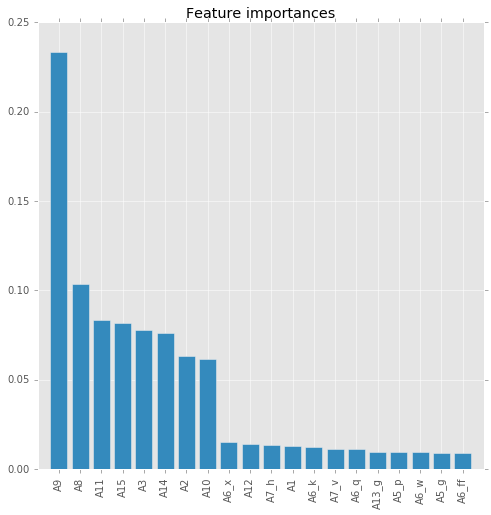

In [21]:
# построим диаграмму
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

best_features = indices[:8]
best_features_names = feature_names[best_features]
print(best_features_names)

### GBT – градиентный бустинг деревьев решений

In [24]:
# Просто обучаем GBT модель
from sklearn import ensemble
gbt = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))
print err_train, err_test

# Используем только лучшие фичи
gbt = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
gbt.fit(X_train[best_features_names], y_train)

err_train = np.mean(y_train != gbt.predict(X_train[best_features_names]))
err_test = np.mean(y_test != gbt.predict(X_test[best_features_names]))
print err_train, err_test

#Ищем лучшее значение n_estimators
from sklearn.grid_search import GridSearchCV
n_estimators_array = [90,100,110,125,150,200,250,275,300,325]
grid = GridSearchCV(gbt, param_grid={'n_estimators' : n_estimators_array})
grid.fit(X_train[best_features_names], y_train)
print 'CV error    = ', 1 - grid.best_score_
print 'best C      = ', grid.best_estimator_.n_estimators

# Обучаем на основании лучшего значения
gbt = ensemble.GradientBoostingClassifier(n_estimators=grid.best_estimator_.n_estimators, 
                                     random_state=11)
gbt.fit(X_train[best_features_names], y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))
print err_train, err_test

0.0248447204969 0.101449275362
0.0351966873706 0.106280193237
CV error    =  0.138716356108
best C      =  325
0.0 0.106280193237
